In [1]:
# importing some vital libaries

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataset = tf.data.Dataset.range(10)

for val in dataset:
    print(val.numpy())

0
1
2
3
4
5
6
7
8
9


In [4]:
dataset = tf.data.Dataset.range(10)
# we'll create a window, whose max_length is 5 and we'll shift by 1.
dataset = dataset.window(5, shift=1)
for window_dataset in dataset:
    for val in window_dataset: 
        print(val.numpy(), end=' ')
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


In [8]:
dataset = tf.data.Dataset.range(10)
# we'll create a window, whose max_length is 5 and we'll shift by 1
# and making windows equal by mentioning drop_reminder = True. 
dataset = dataset.window(5, shift=1, drop_remainder=True)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=" ")
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


 We have 6 windows, each window size is . If the values of the window are not equal to the window_size, it will terminate that window. Example compare the above 2 cells.

In [10]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
# flatting the data and making batches.
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
    print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [12]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
# seperating the data into features and labels.
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x,y in dataset:
    print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [14]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
#shuffling the data.
dataset = dataset.shuffle(buffer_size = 10)
for x,y in dataset:
    print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[5 6 7 8] [9]
[4 5 6 7] [8]
[2 3 4 5] [6]
[3 4 5 6] [7]


In [16]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[1:]))
dataset = dataset.shuffle(buffer_size=10)
# after shuffling I'll make a batch of 2 with the windows.
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
    print('x=', x.numpy())
    print('y=', y.numpy())

x= [[0 1 2 3]
 [1 2 3 4]]
y= [[1 2 3 4]
 [2 3 4 5]]
x= [[4 5 6 7]
 [2 3 4 5]]
y= [[5 6 7 8]
 [3 4 5 6]]
x= [[5 6 7 8]
 [3 4 5 6]]
y= [[6 7 8 9]
 [4 5 6 7]]


In [17]:
def plot_series(time, series, format_ = '-', start=0, end=None):
    plt.plot(time[start:end], series[start:end], format_)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    
def trend(time, slope=0):
    return slope* time

def seasonal_pattern(season_time):
    return np.where(season_time<0.4,
                   np.cos(season_time * 2 * np.pi),
                   1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level = 1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [60]:
time = np.arange(4 * 365 +1)
base_line = 10
series = trend(time, 0.1)
amplitude= 10
slope=0.05
noise_level = 5

# create the series.
series = base_line + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [61]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [62]:
# we'll use the window dataset , which we created earlier.
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

#creating the model with a Dense layer.
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, input_shape=[window_size])
])
#compiling the model.
model.compile(loss = 'mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum = 0.9))

# lets start the training.
model.fit(dataset, epochs = 100, verbose=1)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>
Epoch 1/100
31/31 [==============================] - 4s 116ms/step - loss: 751.1120
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 104.7187
Epoch 3/100
31/31 [==============================] - 0s 10ms/step - loss: 79.6036
Epoch 4/100
31/31 [==============================] - 0s 11ms/step - loss: 77.1702
Epoch 5/100
31/31 [==============================] - 0s 11ms/step - loss: 75.5937
Epoch 6/100
31/31 [==============================] - 0s 10ms/step - loss: 74.3843
Epoch 7/100
31/31 [==============================] - 0s 10ms/step - loss: 72.8081
Epoch 8/100
31/31 [==============================] - 0s 11ms/step - loss: 71.1595
Epoch 9/100
31/31 [==============================] - 0s 10ms/step - loss: 69.4069
Epoch 10/100
31/31 [==============================] - 0s 16ms/step - loss: 69.0463
Epoch 11/100
31/31 [==============================] - 0s 13ms/step - loss: 67.1148
Epoch 12/1

31/31 [==============================] - 1s 36ms/step - loss: 30.6429
Epoch 99/100
31/31 [==============================] - 1s 22ms/step - loss: 30.1963
Epoch 100/100
31/31 [==============================] - 1s 26ms/step - loss: 30.6726


In [63]:
#  getting the weights.
print(f' weights :{model.get_weights()}')

 weights :[array([[-0.03987177],
       [ 0.01040733],
       [-0.0576453 ],
       [ 0.03392029],
       [ 0.11755193],
       [ 0.09326723],
       [ 0.05995172],
       [-0.06119624],
       [-0.01040708],
       [-0.00614116],
       [ 0.07181039],
       [ 0.04661204],
       [-0.02806887],
       [-0.01590273],
       [ 0.18627203],
       [ 0.05916542],
       [ 0.15558851],
       [ 0.15168373],
       [ 0.14770362],
       [ 0.05994466]], dtype=float32), array([0.00697093], dtype=float32)]


In [71]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
    # adding the predicted values to the new axis.

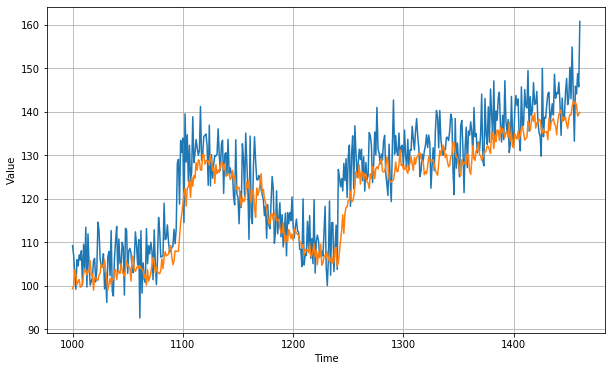

In [72]:
forecast = forecast[split_time-window_size:]
# converting the list into array.
results = np.array(forecast)[:, 0, 0]

# figure size
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [73]:
# calculate the mean_absolute_error

tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.3839602

still not good result. Lets try some thing different.

In [76]:
time = np.arange(4 * 365 +1)
base_line = 10
series = trend(time, 0.1)
amplitude= 10*2  # lets change the amplitude and slope
slope=0.09
noise_level = 5

# create the series.
series = base_line + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

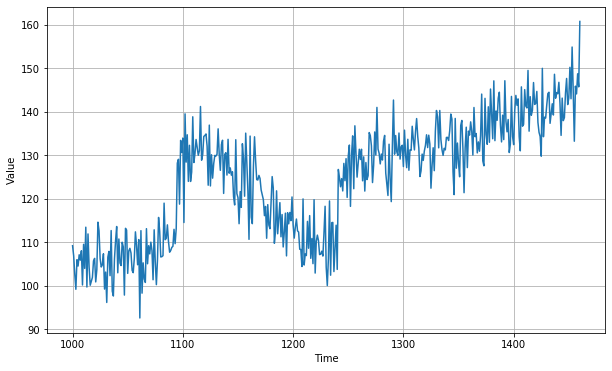

In [77]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [78]:
# lets add some more Dense layers to our model.

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

from tensorflow.keras.layers import Dense
model = tf.keras.models.Sequential([
    # first layer of any model requires input_shape.
    Dense(10, input_shape = [window_size], activation='relu'),
    Dense(10, activation='relu'),
    Dense(1)
    
])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))

model.fit(dataset, epochs=100, # training
         verbose=0 # I don't want the output.
         )

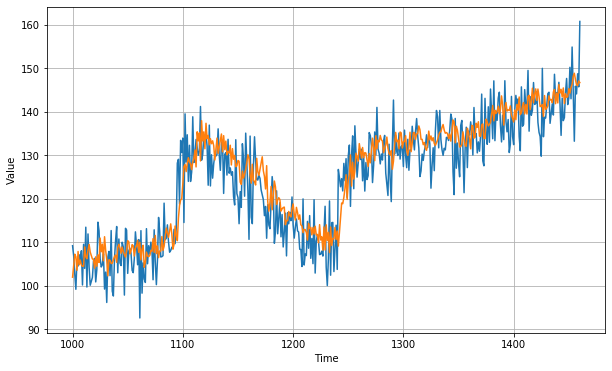

In [79]:
forecast = [] # empyt list

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time+ window_size][np.newaxis]))
    
forecast = forecast[split_time - window_size:] # some little amount of data.
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [80]:
from tensorflow.keras.metrics import mean_absolute_error, mean_squared_error
mean_absolute_error(x_valid, results).numpy()

4.9773955

Comparing to previous result, its a bit better.

In [82]:
# In this cell I'll try to plot multiple learning rates.

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    Dense(10, input_shape=[window_size], activation='relu'),
    Dense(10, activation='relu'),
    Dense(1)
])

# lets try to use callback. After each epoch I'll take learning rate of
# epoch and I'll do some operations on it and finally return that learning rate.
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss='mse', optimizer= optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

[1e-08, 0.001, 0, 300]

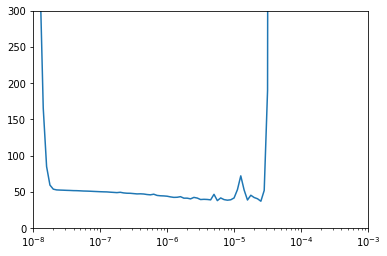

In [83]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-3, 0, 300])

# x-axis = start 10^-8 to 10^-3
# y-axis = start from 0 to 300.

In [88]:
# lets set the window_size
window_size = 30

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Creating the model.
model = tf.keras.models.Sequential([
    Dense(10, activation='relu', input_shape=[window_size]),
    Dense(10, activation='relu'),
    Dense(1)
])

# we'll change the learning rate. (8x 10^-6).
optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)

# comiple the model
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

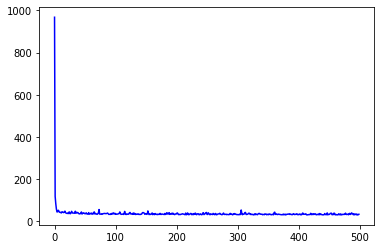

In [89]:
#lets plot the graph.

loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

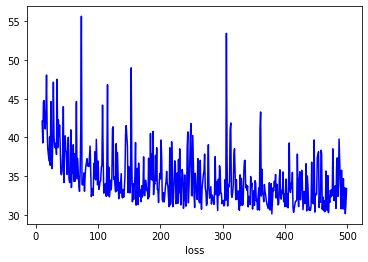

In [90]:
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
# print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.xlabel('loss')

plt.show()

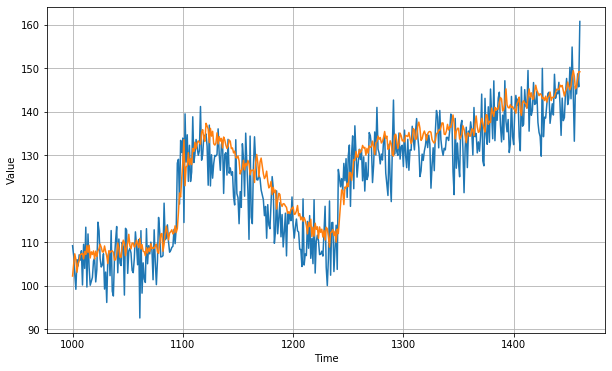

In [91]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time: time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]
plt.figure(figsize=(10, 6))

# lets plot Actual data with the predicted data.
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [92]:
mean_absolute_error(x_valid, results).numpy()

5.073047

Last result was good better than the current one.